In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Data/100_Unique_QA_Dataset.csv')

In [3]:
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


In [4]:
## tokenizize

def tokeniz(text):
  text = text.lower()
  text = text.replace("?","")
  text = text.replace("'","")
  return text.split()

In [5]:
tokeniz("What is the largest planet in our solar system?	")

['what', 'is', 'the', 'largest', 'planet', 'in', 'our', 'solar', 'system']

In [6]:
## vocab
vocab = {'<unk>':0}

In [7]:
def build_vocab(row):

  tokenized_que = tokeniz(row['question'])
  tokenized_ans = tokeniz(row['answer'])

  merge_tokeniz = tokenized_que + tokenized_ans

  for token in merge_tokeniz:

    if token not in vocab:
      vocab[token] = len(vocab)


In [8]:
print(vocab)

{'<unk>': 0}


In [9]:
df.apply(build_vocab,axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [10]:
len(vocab)

324

In [11]:
# converting word to numerical indices
def text_to_indices(text, vocab):
  indexed_text = []

  for token in tokeniz(text):
    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<unk>'])

  return indexed_text

In [12]:
  text_to_indices("What is my name", vocab)

[1, 2, 0, 0]

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
class QADataset(Dataset):

  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):

    numeric_ques = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numeric_ans = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

    return torch.tensor(numeric_ques), torch.tensor(numeric_ans)

In [16]:
dataset = QADataset(df, vocab)

In [17]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size = 1, shuffle = True)

## Our RNN structure
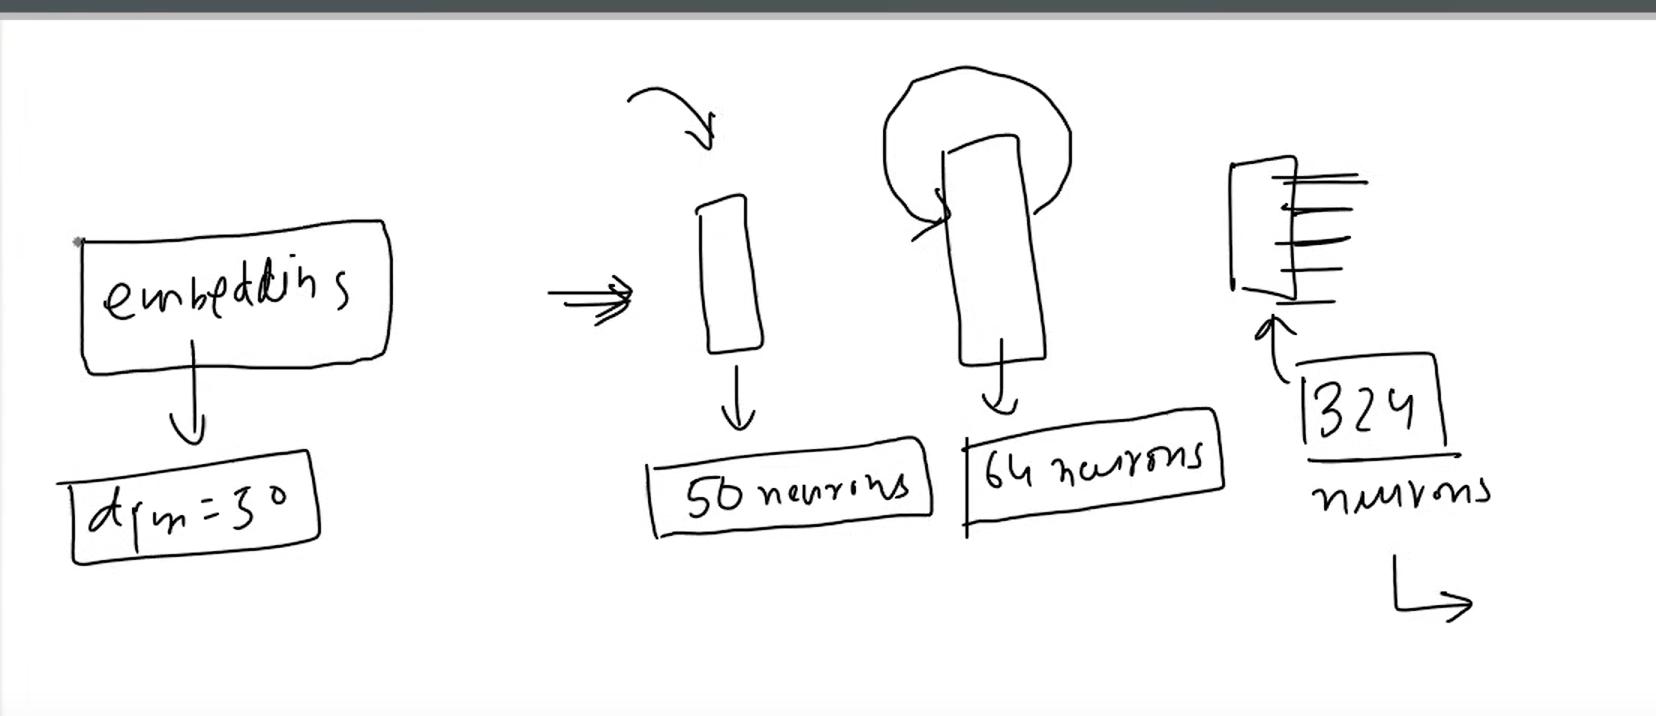

In [18]:
import torch.nn as nn

In [20]:
# Import necessary PyTorch modules
import torch.nn as nn

# Define a simple RNN-based model
class SimpleRNN(nn.Module):

    def __init__(self, vocab_size):
        """
        Constructor to initialize the model layers.

        Args:
        - vocab_size: Size of the vocabulary (number of unique tokens). Determines input and output dimensions.
        """
        super().__init__()

        # Embedding layer: Converts input word indices to dense vectors of size 50
        self.embedding = nn.Embedding(vocab_size, embedding_dim=50)

        # RNN layer: Takes embeddings of size 50 and outputs hidden states of size 64
        # batch_first=True makes the input/output tensors in (batch, seq, feature) format
        self.rnn = nn.RNN(input_size=50, hidden_size=64, batch_first=True)

        # Fully connected (Linear) layer: Maps the final hidden state (64) to vocab size
        # Used to predict the next word in vocabulary
        self.fc = nn.Linear(in_features=64, out_features=vocab_size)

    def forward(self, question):
        """
        Forward pass of the model.

        Args:
        - question: Tensor of shape (batch_size, seq_length) containing word indices

        Returns:
        - output: Tensor of shape (batch_size, vocab_size), the predicted distribution over vocabulary
        """

        # Convert input word indices to embeddings of shape (batch_size, seq_length, 50)
        embedded_question = self.embedding(question)

        # Pass embeddings through the RNN
        # `hidden` contains all hidden states for each time step
        # `final` contains the last hidden state of the RNN
        hidden, final = self.rnn(embedded_question)

        # Remove the extra dimension (squeeze) from the final hidden state
        # `final` is of shape (1, batch_size, 64) --> becomes (batch_size, 64)
        output = self.fc(final.squeeze(0))

        # Return the logits for each word in the vocabulary
        return output


In [21]:
x = nn.Embedding(324, embedding_dim=50)
y = nn.RNN(50, 64, batch_first=True)
z = nn.Linear(64, 324)

a = dataset[0][0].reshape(1,6)
print("shape of a:", a.shape)
b = x(a)
print("shape of b:", b.shape)
c, d = y(b)
print("shape of c:", c.shape)
print("shape of d:", d.shape)

e = z(d.squeeze(0))

print("shape of e:", e.shape)

shape of a: torch.Size([1, 6])
shape of b: torch.Size([1, 6, 50])
shape of c: torch.Size([1, 6, 64])
shape of d: torch.Size([1, 1, 64])
shape of e: torch.Size([1, 324])


In [22]:
learning_rate = 0.001
epochs = 50

In [23]:
model = SimpleRNN(len(vocab))

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:

for epoch in range(epochs):

    total_loss = 0


    for question, answer in dataloader:

        # Step 1: Zero out any gradients from previous backward pass
        optimizer.zero_grad()

        # Step 2: Forward pass – get model predictions
        output = model(question)
        # 'output' shape is (batch_size, vocab_size), typically (1, 324)

        # Step 3: Compute loss between prediction and true label
        # answer[0] is used assuming answer is a single element tensor like tensor([23])
        # criterion can be CrossEntropyLoss which expects (batch_size, vocab_size) and targets as class indices
        loss = criterion(output, answer[0])

        # Step 4: Backward pass – compute gradients
        loss.backward()

        # Step 5: Update weights using optimizer (e.g., SGD, Adam)
        optimizer.step()

        # Accumulate loss for monitoring
        total_loss += loss.item()

    # Print epoch-wise loss after one full pass through the data
    print(f"Epoch: {epoch+1}, Loss: {total_loss:.4f}")


Epoch: 1, Loss: 523.1895
Epoch: 2, Loss: 453.9897
Epoch: 3, Loss: 374.0681
Epoch: 4, Loss: 310.7386
Epoch: 5, Loss: 258.2889
Epoch: 6, Loss: 209.4280
Epoch: 7, Loss: 166.5260
Epoch: 8, Loss: 129.6316
Epoch: 9, Loss: 99.0708
Epoch: 10, Loss: 75.6422
Epoch: 11, Loss: 58.1707
Epoch: 12, Loss: 45.4361
Epoch: 13, Loss: 35.8719
Epoch: 14, Loss: 29.1122
Epoch: 15, Loss: 23.9405
Epoch: 16, Loss: 19.7989
Epoch: 17, Loss: 16.7539
Epoch: 18, Loss: 14.2382
Epoch: 19, Loss: 12.2185
Epoch: 20, Loss: 10.6466
Epoch: 21, Loss: 9.3353
Epoch: 22, Loss: 8.2424
Epoch: 23, Loss: 7.3154
Epoch: 24, Loss: 6.5607
Epoch: 25, Loss: 5.8816
Epoch: 26, Loss: 5.3410
Epoch: 27, Loss: 4.8166
Epoch: 28, Loss: 4.3982
Epoch: 29, Loss: 4.0131
Epoch: 30, Loss: 3.6799
Epoch: 31, Loss: 3.3863
Epoch: 32, Loss: 3.1225
Epoch: 33, Loss: 2.8874
Epoch: 34, Loss: 2.6705
Epoch: 35, Loss: 2.4793
Epoch: 36, Loss: 2.3077
Epoch: 37, Loss: 2.1463
Epoch: 38, Loss: 1.9986
Epoch: 39, Loss: 1.8681
Epoch: 40, Loss: 1.7474
Epoch: 41, Loss: 1.63

In [26]:
def predict(model, question, threshold=0.5):
    """
    Predicts the next word for a given input question using the trained model.

    Args:
    - model: Trained RNN model
    - question: Input string (e.g., "What is your")
    - threshold: Confidence threshold below which the model refuses to guess

    Returns:
    - Prints the predicted word or "I don't know" if confidence is low
    """

    # Step 1: Convert input text to indices using vocabulary
    # For example, "hello world" -> [12, 58]
    numerical_question = text_to_indices(question, vocab)

    # Step 2: Convert list of indices into a PyTorch tensor and add batch dimension
    # Shape becomes (1, sequence_length)
    question_tensor = torch.tensor(numerical_question).unsqueeze(0)

    # Step 3: Run the model to get raw output logits (before softmax)
    output = model(question_tensor)  # Shape: (1, vocab_size)

    # Step 4: Convert logits to probabilities using softmax
    probs = torch.nn.functional.softmax(output, dim=1)  # Shape: (1, vocab_size)

    # Step 5: Get the max probability and its index (predicted word)
    value, index = torch.max(probs, dim=1)  # value: tensor of shape (1), index: tensor (1)

    # Step 6: Check if model's confidence is below threshold
    if value < threshold:
        print("I don't know")
        return

    # Step 7: Map the predicted index back to the actual word using vocab
    predicted_word = list(vocab.keys())[index]
    print(predicted_word)


In [27]:
predict(model, "ask question here")

I don't know
